### Explorative Analyse der Smartmeter Daten

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../03_src"))

import seaborn as sns
import matplotlib as plt
import polars as pl

from data_loader import processed_data_load
path_to_file = "../02_data/processed/combined_data_cleaned.parquet"
df_cleaned = processed_data_load(path_to_file)

✅ Processed Data geladen: 937456 Zeilen, 140 Spalten.


In [15]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def create_bivariate_plots(df):
    # Zuordnung von Variablennamen zu lesbaren Achsenbeschriftungen
    label_map = {
        "building_floorareaheated_total": "Beheizte Gesamtfläche [m²]",
        "kwh_received_total": "Gesamtstromverbrauch [kWh]",
        "building_residents": "Anzahl Bewohner",
        "heatpump_installation_type": "Wärmepumpen-Typ",
        "kwh_received_heatpump": "Stromverbrauch Wärmepumpe [kWh]",
        "heatpump_installation_normpoint_cop": "Norm-COP (Wirkungsgrad)",
        "heatpump_installation_incorrectlyplanned_categorization": "Planungsstatus (Dimensionierung)",
        "heatpump_clean": "Zustand (Sauberkeit)",
        "heatingdegree_sia_daily": "Heizgradtage [SIA-Standard]"
    }

    analysis_groups = [
        {"title": "Gebäude-Dimensionen & Grundlast", 
         "pairs": [("building_floorareaheated_total", "kwh_received_total", "scatter"), 
                   ("building_residents", "kwh_received_total", "box")]},
        {"title": "Wärmepumpen-Technik & Effizienz", 
         "pairs": [("heatpump_installation_type", "kwh_received_heatpump", "box"), 
                   ("heatpump_installation_normpoint_cop", "kwh_received_heatpump", "scatter")]},
        {"title": "Wartung & Fehlplanung", 
         "pairs": [("heatpump_installation_incorrectlyplanned_categorization", "kwh_received_heatpump", "box"), 
                   ("heatpump_clean", "kwh_received_heatpump", "box")]},
        {"title": "Witterungseinfluss", 
         "pairs": [("heatingdegree_sia_daily", "kwh_received_heatpump", "scatter")]}
    ]

    for group in analysis_groups:
        num_plots = len(group["pairs"])
        fig, axes = plt.subplots(1, num_plots, figsize=(7 * num_plots, 6))
        if num_plots == 1: axes = [axes]
        
        fig.suptitle(group["title"], fontsize=16, fontweight='bold')

        for i, (x_col, y_col, ptype) in enumerate(group["pairs"]):
            plot_df = df.select([x_col, y_col]).drop_nulls()
            
            if ptype == "scatter":
                axes[i].scatter(plot_df[x_col], plot_df[y_col], alpha=0.4, color='steelblue', s=10)
                # Korrelation berechnen
                if plot_df[x_col].dtype in [pl.Float64, pl.Int64, pl.Int32]:
                    corr_val = plot_df.select(pl.corr(x_col, y_col)).item()
                    axes[i].set_title(f"Korrelation: {corr_val:.2f}")

            elif ptype == "box":
                sns.boxplot(data=plot_df.to_pandas(), x=x_col, y=y_col, ax=axes[i], palette="Set2")
                axes[i].tick_params(axis='x', rotation=45)

            # Achsenbeschriftungen setzen
            axes[i].set_xlabel(label_map.get(x_col, x_col), fontsize=12)
            axes[i].set_ylabel(label_map.get(y_col, y_col), fontsize=12)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Aufruf der Funktion
# create_bivariate_plots(df_cleaned)

C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\2483333874.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df.to_pandas(), x=x_col, y=y_col, ax=axes[i], palette="Set2")


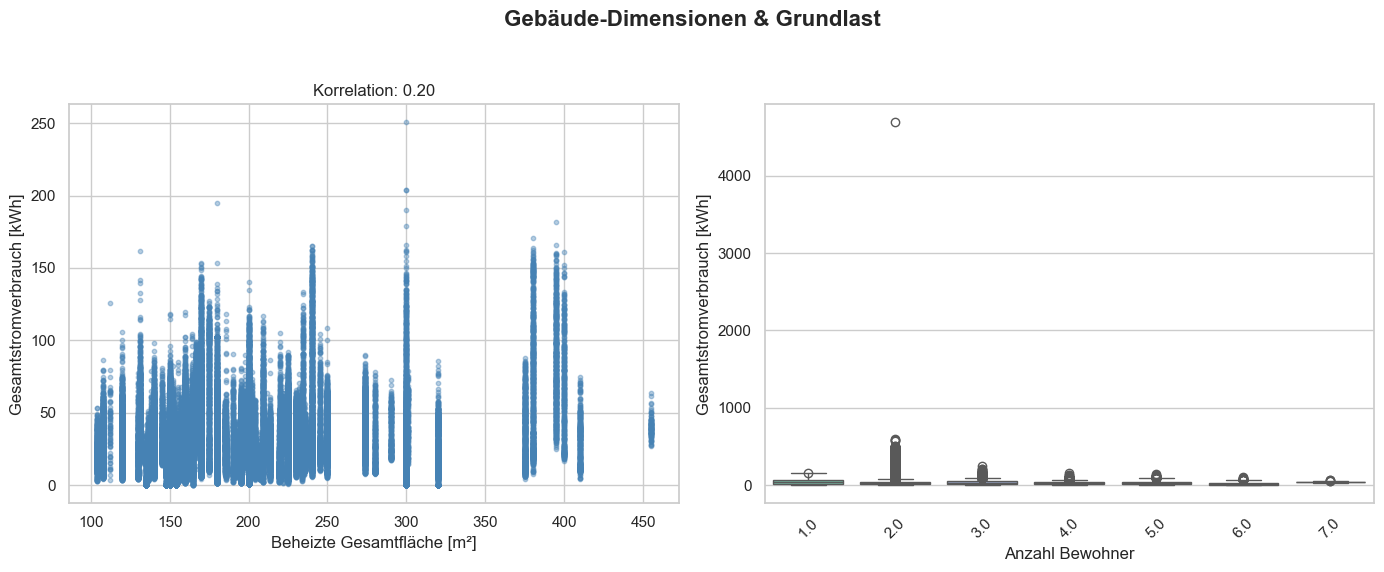

C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\2483333874.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df.to_pandas(), x=x_col, y=y_col, ax=axes[i], palette="Set2")


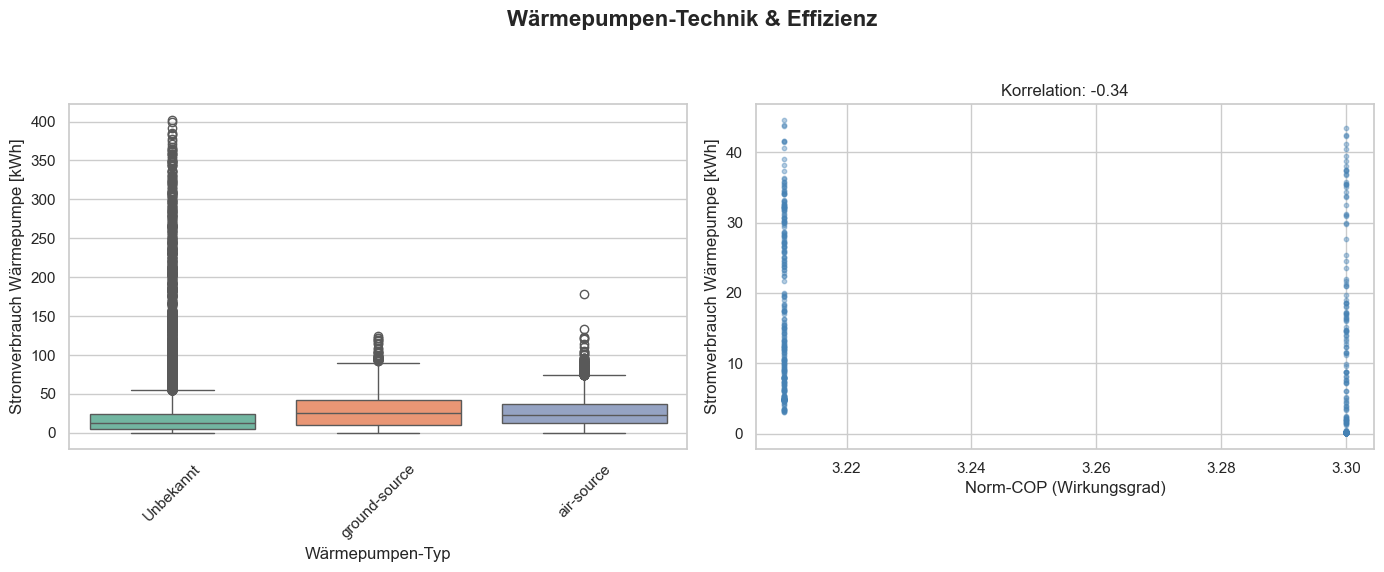

C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\2483333874.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df.to_pandas(), x=x_col, y=y_col, ax=axes[i], palette="Set2")
C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\2483333874.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df.to_pandas(), x=x_col, y=y_col, ax=axes[i], palette="Set2")


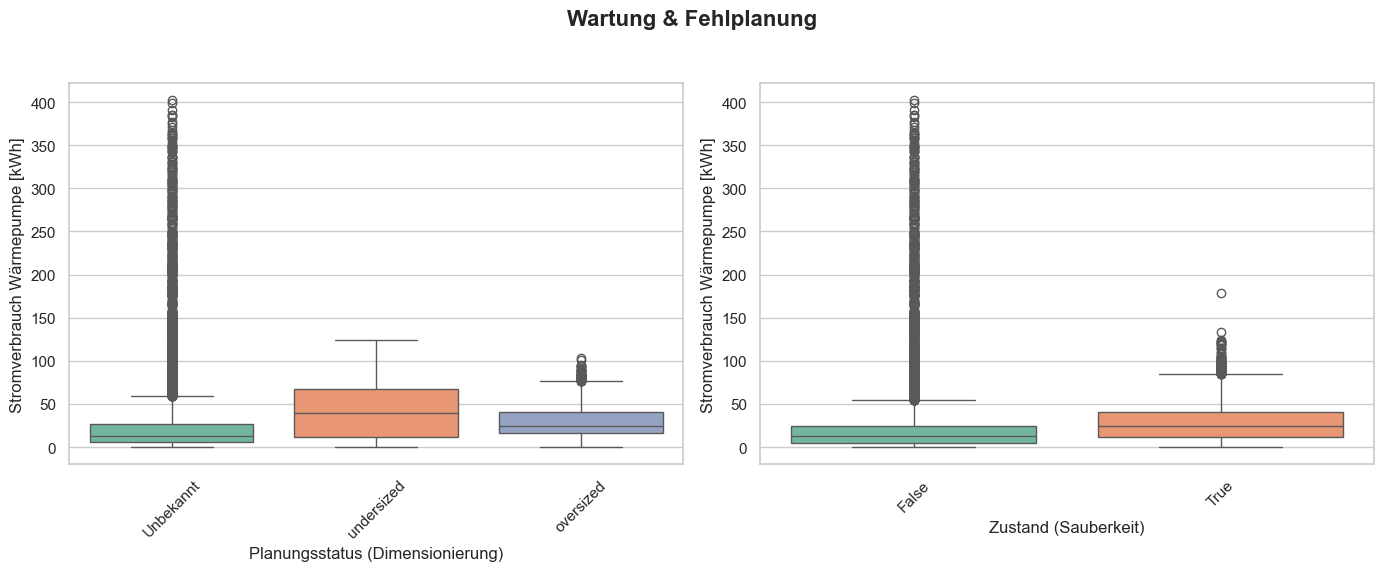

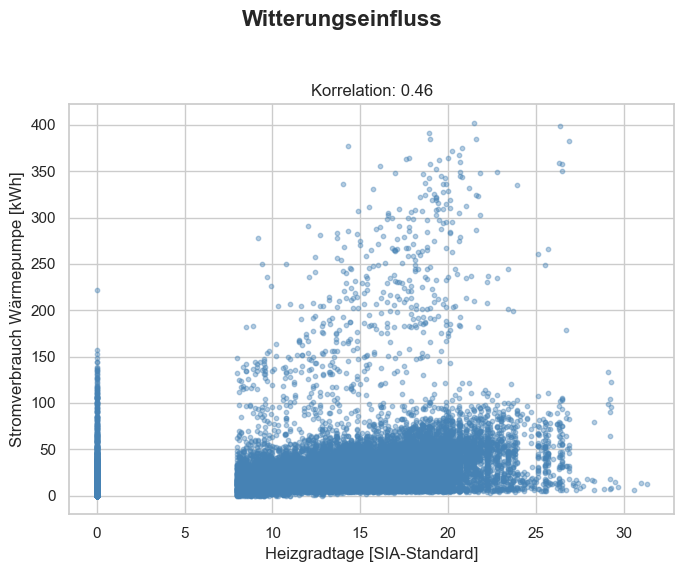

In [16]:
create_bivariate_plots(df_cleaned)

In [13]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_full_energy_analysis(df: pl.DataFrame):
    """
    Kombiniert statische Gebäudeanalyse, bivariate Effizienzprüfung 
    und multivariate Korrelationen.
    """
    # Styling
    sns.set_theme(style="whitegrid")
    
    # ---------------------------------------------------------
    # TEIL 1: Statische Merkmale (Deine frühere Idee, korrigiert)
    # ---------------------------------------------------------
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle("Gebäudestruktur & Statische Merkmale", fontsize=20, fontweight='bold')

    # 1. Baujahr & Fenster-Renovierung
    sns.histplot(data=df.to_pandas(), x="building_constructionyear", hue="building_renovated_windows", 
                 multiple="stack", palette="viridis", bins=20, ax=axes1[0, 0])
    axes1[0, 0].set_title("Baujahre & Sanierungsstatus")

    # 2. Beheizte Fläche vs. Bewohner (Treiber für DHW)
    sns.scatterplot(data=df.to_pandas(), x="building_floorareaheated_total", y="building_residents", 
                    alpha=0.6, color="coral", ax=axes1[0, 1])
    axes1[0, 1].set_title("Wohnfläche vs. Anzahl Bewohner")

    # 3. Effizienz nach Typ
    sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop", 
                palette="Set3", ax=axes1[1, 0])
    axes1[1, 0].set_title("Effizienz (COP) nach WP-Typ")

    # 4. PV-Größenverteilung
    pv_df = df.filter(pl.col("building_pvsystem_size") > 0).to_pandas()
    if not pv_df.empty:
        sns.kdeplot(data=pv_df, x="building_pvsystem_size", fill=True, color="gold", ax=axes1[1, 1])
        axes1[1, 1].set_title("Verteilung der PV-Anlagengröße (kWp)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ---------------------------------------------------------
    # TEIL 2: Bivariate & Multivariate Analyse (Neue Anforderungen)
    # ---------------------------------------------------------
    
    # 1. Korrelations-Heatmap (HeatPump_Installation_Normpoint_COP vs. Baujahr etc.)
    corr_cols = [
        'heatpump_installation_normpoint_cop', 
        'building_floorareaheated_total', 
        'building_constructionyear', 
        'heatpump_installation_heatingcapacity'
    ]
    plt.figure(figsize=(10, 8))
    # Polars drop_nulls -> Pandas corr() -> Seaborn heatmap
    sns.heatmap(df.select(corr_cols).drop_nulls().to_pandas().corr(), 
                annot=True, cmap='RdYlGn', center=0, fmt=".2f")
    plt.title("Korrelations-Heatmap: Effizienz-Faktoren", fontsize=16, fontweight='bold')
    plt.show()

    # 2. 2D-Histogramm: Baujahr vs. WP-Installationsjahr (Zeitliche Verteilung)
    plt.figure(figsize=(10, 7))
    # Wir nutzen Series.drop_nulls() für das Histogramm
    x = df.select("building_constructionyear").to_series().drop_nulls()
    y = df.select("heatpump_installation_year").to_series().drop_nulls()
    plt.hist2d(x, y, bins=30, cmap='YlOrRd')
    plt.colorbar(label='Anzahl Haushalte')
    plt.xlabel("Gebäude Baujahr")
    plt.ylabel("WP Installationsjahr")
    plt.title("Zeitliche Verteilung: WP-Installationen in Alt- vs. Neubauten")
    plt.show()

    # 3. Violin-Plot: Heizkurven-Änderung nach Beratung (Differenz)
    # Berechnung der Reduktion durch die Energieberatung
    df_curve = df.with_columns([
        (pl.col("heatpump_heatingcurvesetting_outside0_beforevisit") - 
         pl.col("heatpump_heatingcurvesetting_outside0_aftervisit")).alias("curve_reduction")
    ]).select(["heatpump_installation_type", "curve_reduction"]).drop_nulls()

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df_curve.to_pandas(), x="heatpump_installation_type", y="curve_reduction", inner="quartile")
    plt.title("Auswirkung der Beratung: Reduktion der Heizkurve (bei 0°C Außentemp.)")
    plt.ylabel("Temperatur-Reduktion [K]")
    plt.show()

    # 4. Statistisches Feature Ranking (Ersatz für Random Forest Importance)
    target = "heatpump_technicallyokay"
    features = ["heatpump_clean", "building_renovated_roof", "building_renovated_walls", "heatpump_installation_correctlyplanned"]
    
    rankings = []
    for feat in features:
        # Konvertierung zu Int für Korrelation von Booleans
        temp_df = df.select([feat, target]).drop_nulls().with_columns(pl.all().cast(pl.Int64))
        # Korrektur des Polars API Zugriffs: .item() extrahiert den Skalar
        if temp_df.height > 0:
            c_val = temp_df.select(pl.corr(feat, target)).item()
            rankings.append({"Feature": feat, "Korrelation": c_val})
    
    ranking_df = pl.DataFrame(rankings).sort("Korrelation", descending=True)
    print("\nRanking der Treiber für technischen Zustand (Korrelation):")
    print(ranking_df)

# Start der Analyse
# run_full_energy_analysis(df_cleaned)

C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\3571050634.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop",


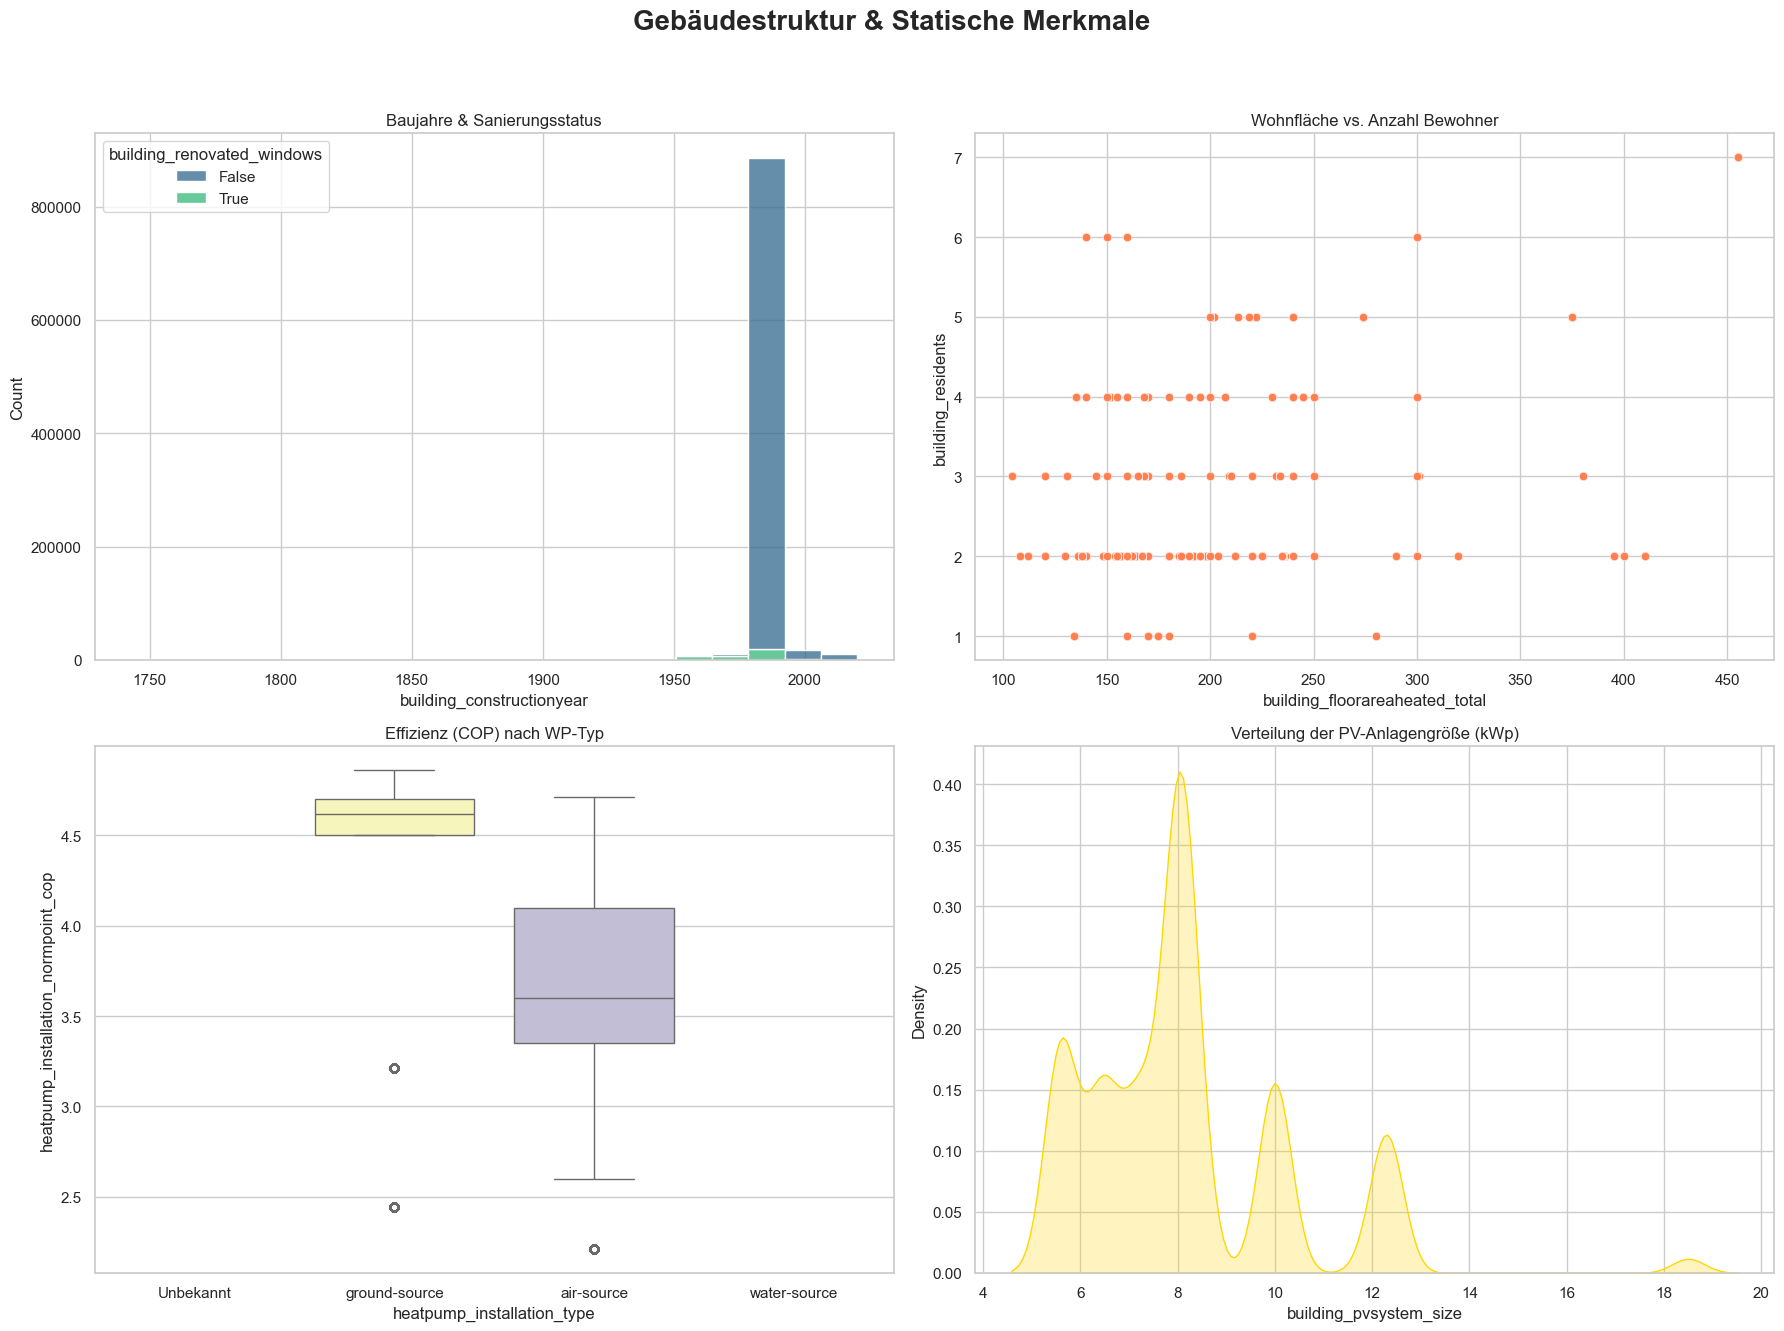

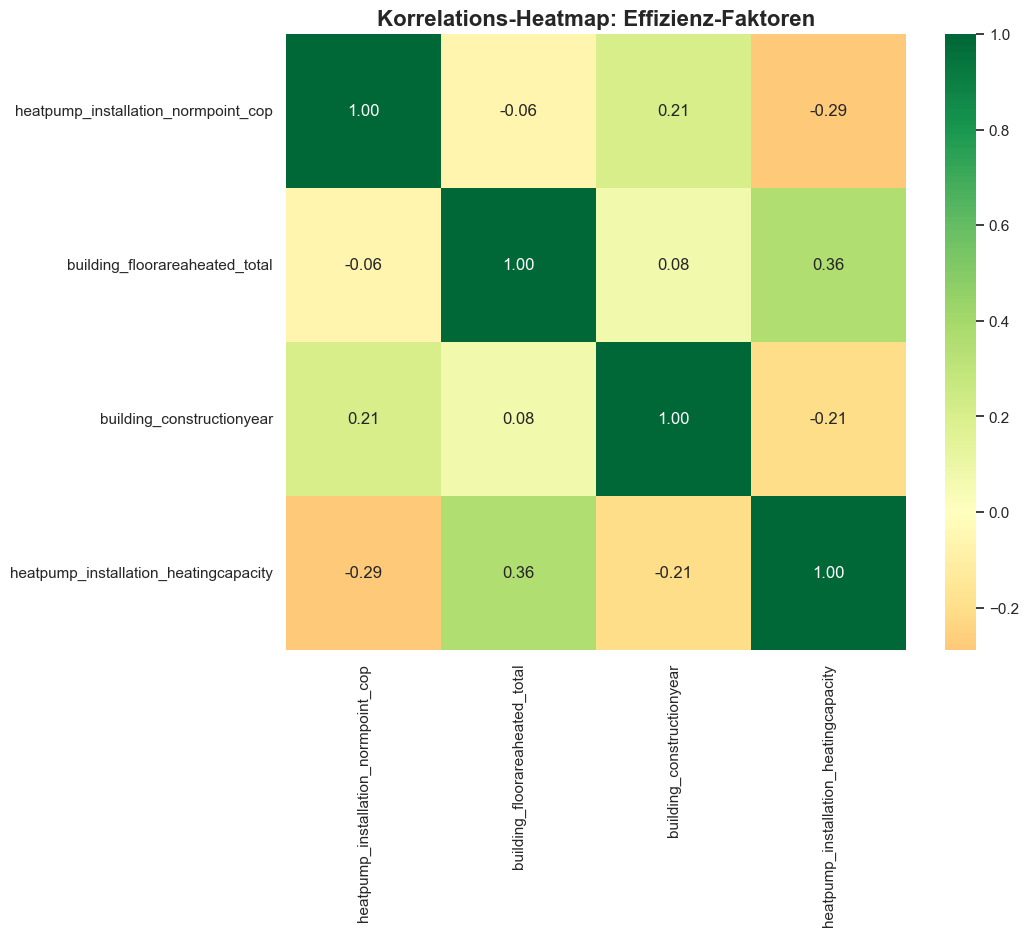

ValueError: x and y must have the same length.

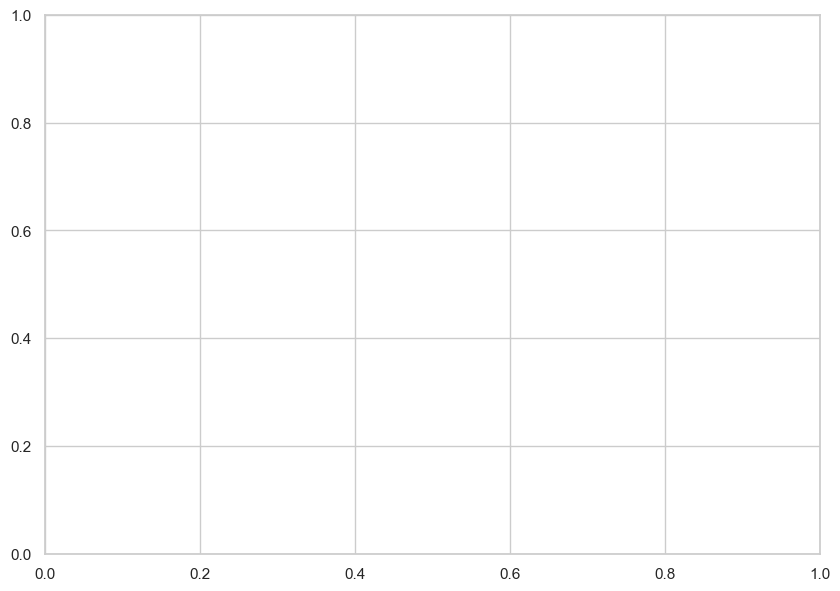

In [14]:
run_full_energy_analysis(df_cleaned)

C:\Users\maxkr\AppData\Local\Temp\ipykernel_24584\1037712423.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop",


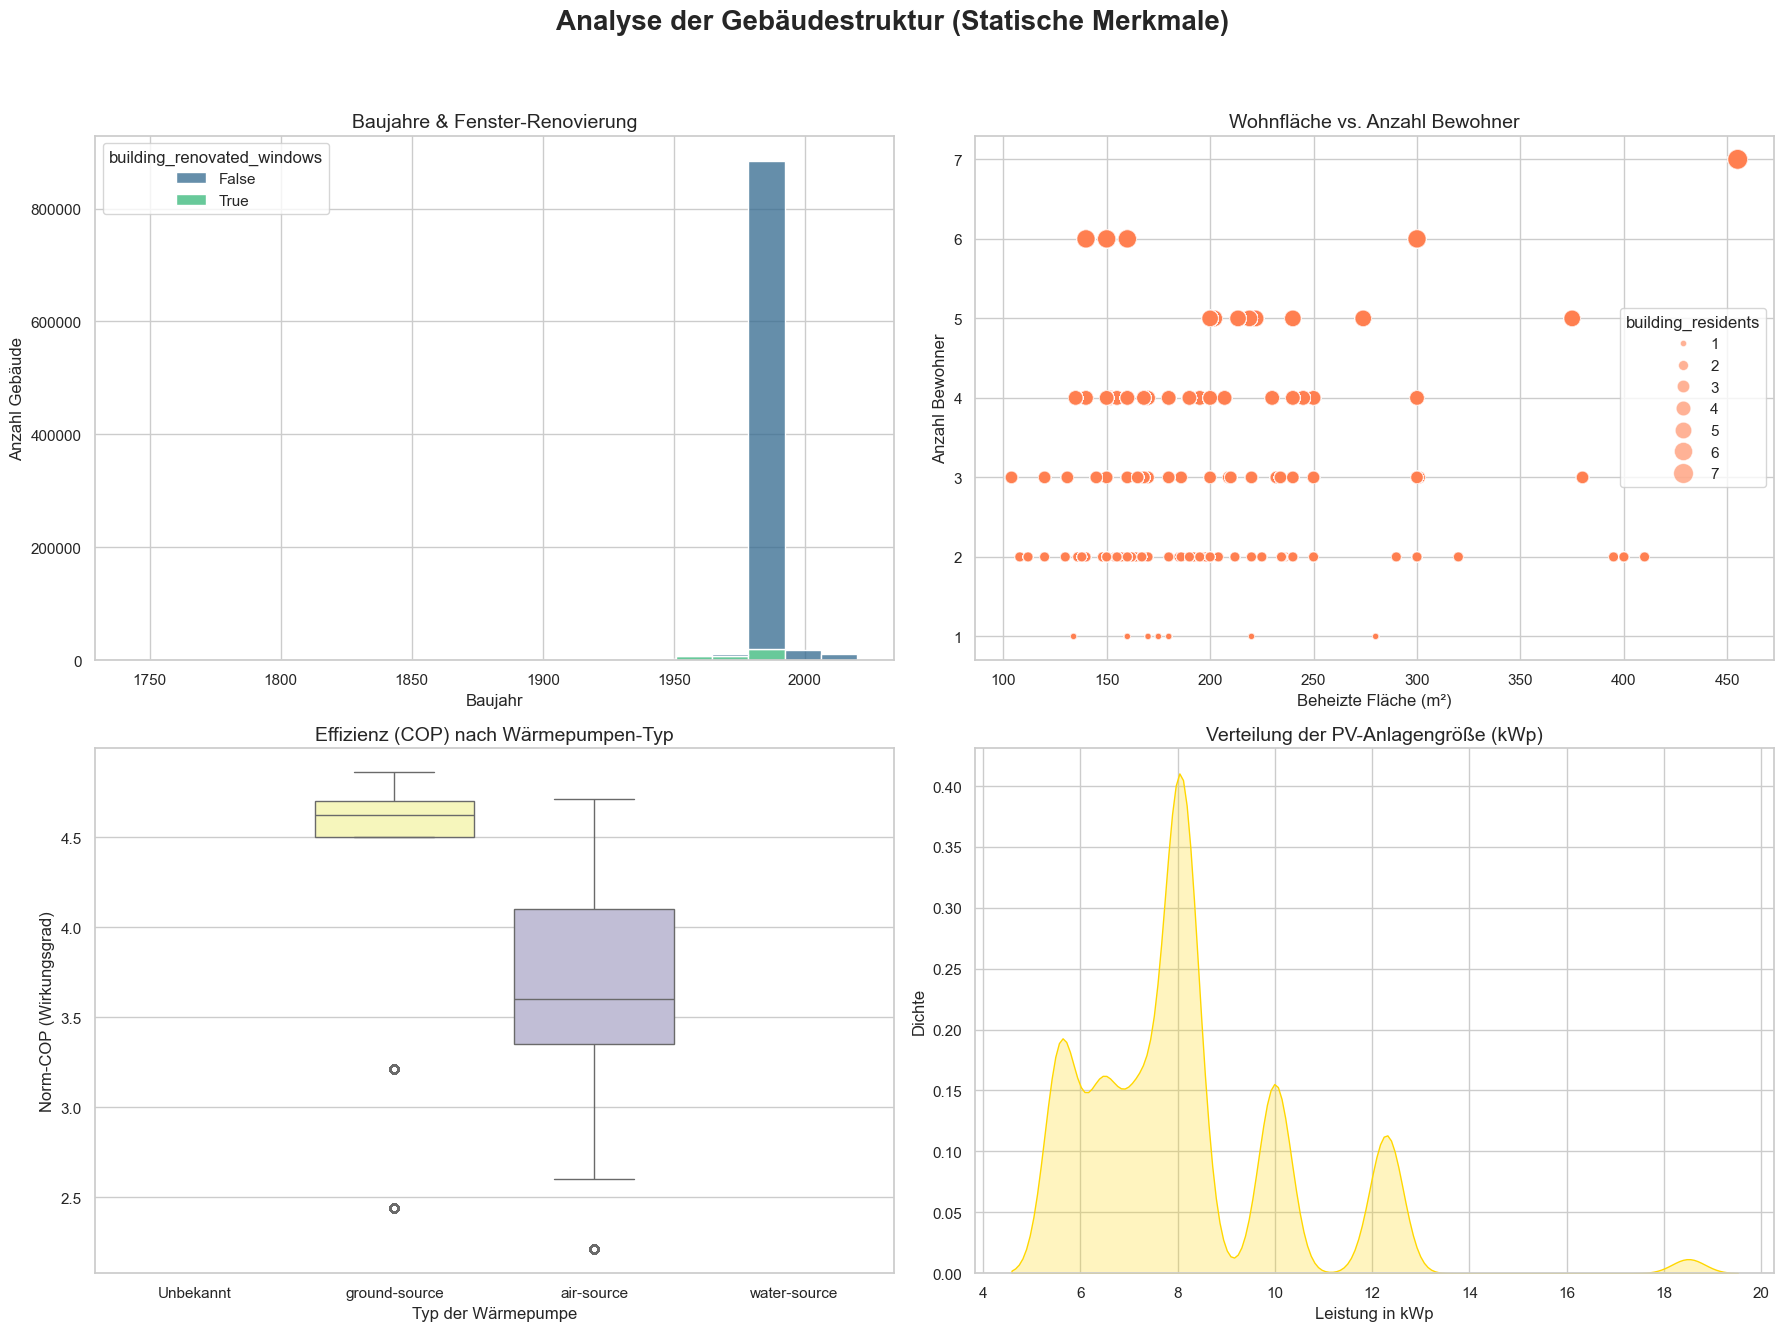

In [17]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_building_analysis(df: pl.DataFrame):
    # Styling
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle("Analyse der Gebäudestruktur (Statische Merkmale)", fontsize=20, fontweight='bold')

    # 1. Baujahr & Renovierungsstatus
    # Wir kombinieren das Baujahr mit der Info, ob Fenster renoviert wurden
    plt.subplot(2, 2, 1)
    sns.histplot(data=df_cleaned.to_pandas(), x="building_constructionyear", hue="building_renovated_windows", 
                 multiple="stack", palette="viridis", bins=20)
    plt.title("Baujahre & Fenster-Renovierung", fontsize=14)
    plt.xlabel("Baujahr")
    plt.ylabel("Anzahl Gebäude")

    # 2. Beheizte Fläche vs. Anzahl Bewohner
    # Wichtig für den Warmwasserverbrauch (DHW)
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df.to_pandas(), x="building_floorareaheated_total", y="building_residents", 
                    alpha=0.6, size="building_residents", sizes=(20, 200), color="coral")
    plt.title("Wohnfläche vs. Anzahl Bewohner", fontsize=14)
    plt.xlabel("Beheizte Fläche (m²)")
    plt.ylabel("Anzahl Bewohner")

    # 3. Wärmepumpen-Technologie nach COP (Wirkungsgrad)
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop", 
                palette="Set3")
    plt.title("Effizienz (COP) nach Wärmepumpen-Typ", fontsize=14)
    plt.xlabel("Typ der Wärmepumpe")
    plt.ylabel("Norm-COP (Wirkungsgrad)")

    # 4. PV-Größe Verteilung (für die Haushalte mit PV)
    plt.subplot(2, 2, 4)
    pv_data = df.filter(pl.col("building_pvsystem_size") > 0).to_pandas()
    sns.kdeplot(data=pv_data, x="building_pvsystem_size", fill=True, color="gold")
    plt.title("Verteilung der PV-Anlagengröße (kWp)", fontsize=14)
    plt.xlabel("Leistung in kWp")
    plt.ylabel("Dichte")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Aufruf mit deinem Metadaten-DataFrame
plot_building_analysis(df_cleaned)